# Multibin Coupled HistoSys


In [1]:
import logging
import json
import numpy as np
import matplotlib.pyplot as plt

import pyhf
from pyhf import Model
from pyhf.contrib.viz import brazil

logging.basicConfig(level=logging.INFO)

In [2]:
def prep_data(sourcedata):
    spec = {
        "channels": [
            {
                "name": "signal",
                "samples": [
                    {
                        "name": "signal",
                        "data": sourcedata["signal"]["bindata"]["sig"],
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "bkg1",
                        "data": sourcedata["signal"]["bindata"]["bkg1"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["signal"]["bindata"][
                                        "bkg1_dn"
                                    ],
                                    "hi_data": sourcedata["signal"]["bindata"][
                                        "bkg1_up"
                                    ],
                                },
                            }
                        ],
                    },
                    {
                        "name": "bkg2",
                        "data": sourcedata["signal"]["bindata"]["bkg2"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["signal"]["bindata"][
                                        "bkg2_dn"
                                    ],
                                    "hi_data": sourcedata["signal"]["bindata"][
                                        "bkg2_up"
                                    ],
                                },
                            }
                        ],
                    },
                ],
            },
            {
                "name": "control",
                "samples": [
                    {
                        "name": "background",
                        "data": sourcedata["control"]["bindata"]["bkg1"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["control"]["bindata"][
                                        "bkg1_dn"
                                    ],
                                    "hi_data": sourcedata["control"]["bindata"][
                                        "bkg1_up"
                                    ],
                                },
                            }
                        ],
                    }
                ],
            },
        ]
    }
    pdf = Model(spec)
    data = []
    for c in pdf.spec["channels"]:
        data += sourcedata[c["name"]]["bindata"]["data"]
    data = data + pdf.config.auxdata
    return data, pdf

In [3]:
# validation_datadir = "../../validation/data"
validation_datadir = "../../../validation/data"

In [4]:
source = json.load(open(validation_datadir + "/2bin_2channel_coupledhisto.json"))

data, model = prep_data(source["channels"])

print(data)

init_pars = model.config.suggested_init()
par_bounds = model.config.suggested_bounds()

unconpars = pyhf.infer.mle.fit(data, model, init_pars, par_bounds)
print(f"parameters post unconstrained fit: {unconpars}")

conpars = pyhf.infer.mle.fixed_poi_fit(0.0, data, model, init_pars, par_bounds)
print(f"parameters post constrained fit: {conpars}")

model.expected_data(conpars)

INFO:pyhf.pdf:Validating spec against schema: model.json
INFO:pyhf.pdf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier coupled_histosys (1 new nuisance parameters)


[170.0, 220.0, 110.0, 105.0, 0.0]
parameters post unconstrained fit: [9.12046336e-13 2.21657952e+00]
parameters post constrained fit: [0.         2.21657983]


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


array([116.08289914, 133.24869741, 183.24869741,  98.08810951,
         2.21657983])

In [5]:
poi_tests = np.linspace(0, 5, 61)
obs_limit, exp_limits, (poi_tests, tests) = pyhf.infer.intervals.upperlimit(
    data, model, poi_tests, level=0.05, return_results=True
)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/infer/calculators.py:352: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/infer/calculators.py:352: RuntimeWarning: divide by zero encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/infer/calculators.py:400: RuntimeWarning: invalid value encountered in true_divide
  CLs = tensorlib.astensor(CLsb / CLb)


expected upper limits: [array(1.25755017), array(1.42075249), array(1.67472765), array(2.03947113), array(2.48889062)]
observed upper limit : nan


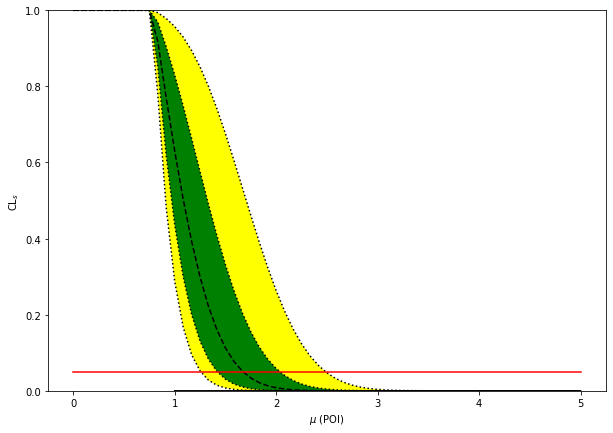

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
brazil.plot_results(ax, poi_tests, tests, test_size=0.05)
print(f'expected upper limits: {exp_limits}')
print(f'observed upper limit : {obs_limit}')